In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet_v2 import preprocess_input
#from tensorflow.keras.applications.efficientnet import preprocess_input
#from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import ImageFile
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import cv2
import openpyxl
import os
import random
import os
import glob
import math
from sklearn.metrics import roc_curve, roc_auc_score
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
print(tf.__version__)

2.6.0


In [2]:
#For repeteable experiments
from numpy.random import seed
def seed_all(seed=1):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_all(1)

In [3]:
IMAGE_SIZE = 299
EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
PATIENCE = 5
nds=3

In [4]:
def evaluate(model):
    datagen = ImageDataGenerator(
#        rescale=1.0/255.,
        preprocessing_function=preprocess_input
    )
    gen = datagen.flow_from_dataframe(
        dataframe=df_totaltest,
        directory=base_dir,
        x_col="image", y_col="target2",
        batch_size=1, #BATCH_SIZE
        class_mode='binary',
        shuffle=False,
        target_size=(IMAGE_SIZE, IMAGE_SIZE))
    # Predict
    steps = gen.n // gen.batch_size
    #probs = model.predict_generator(gen, steps=steps, verbose=1)
    probs = model.predict(gen, steps=steps, verbose=1)
    #predictions = np.argmax(probs, axis=1)
    predictions = [np.round(x) for x in probs]
    # Evaluate
    try:
        classes = list(gen.class_indices.keys())
        report = classification_report(
            gen.classes,
            predictions, 
            target_names=classes
        )
    except:
        counter = Counter(gen.classes)
        classes = [ list(gen.class_indices.keys())[list(gen.class_indices.values()).index(x)] for x, _ in counter.items() ]
        report = classification_report(
            gen.classes,
            predictions, 
            target_names=classes
        )
    matrix = confusion_matrix(gen.classes, predictions)
    return report, pd.DataFrame(matrix, index=classes, columns=classes)

In [5]:
def plot_roc_curve (fpr, tpr, label = None, auc = None):
    plt.plot([0,1], [0,1], 'k--') # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.legend(loc='best')
    plt.text(0.60, 0.40, 'AUC:' + str(auc), fontsize=15, color='black')
    plt.grid()

In [6]:
def to_local_csv(df, path, header=False):
    df_dir = os.path.dirname(path)
    df_file = os.path.basename(path)
    if os.path.exists(path):
        os.remove(path)    
    if df_dir != '' and not os.path.isdir(df_dir):
        os.mkdir(df_dir)   
    df.to_csv(path, index=False, header=header)

In [7]:
def predict_probs(model):
    datagen = ImageDataGenerator(
#        rescale=1.0/255.,
        preprocessing_function=preprocess_input
    )
    gen = datagen.flow_from_dataframe(
        dataframe=df_totaltest,
        directory=base_dir,
        x_col="image", y_col="target2",
        batch_size=1, #BATCH_SIZE
        class_mode='binary',
        shuffle=False,
        target_size=(IMAGE_SIZE, IMAGE_SIZE))
    steps = gen.n // gen.batch_size
    probs = model.predict(gen, steps=steps, verbose=1)
    result = pd.DataFrame({'filename': gen.filenames})
    result['probability'] = probs
    result['prediction'] = [class2 if np.round(x[0]) > 0 else class1 for x in probs]
    return result

In [8]:
##Datos

In [9]:
base_dir = 'images/'
class1 = 'menor'
class2 = 'mayor'

In [10]:
##MOdelo transfer learning Fine tuning

In [11]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

pre_trained_model = ResNet152V2(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), 
                                include_top = False, 
                                weights = "imagenet")


pre_trained_model.trainable = True

set_trainable = False


pre_trained_model.summary()


Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [12]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

for layer in pre_trained_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
pre_trained_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [13]:
model = Sequential()
model.add(pre_trained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 10, 10, 2048)      58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0

In [14]:
# Metrics to use for compiling the model
#METRICS = [keras.metrics.AUC(name="auc")]
METRICS = 'acc'

In [15]:
# Creating an exponential learning rate scheduler
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=LEARNING_RATE, s=20)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [16]:
# Using callbacks to save model parameters and perform early stopping. Por defecto monitor='val_loss', como hemos especificado AUC, debemos ponerlo aqui
#checkpoint_cb = keras.callbacks.ModelCheckpoint("modelcb.h5", monitor='auc', save_best_only=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("modelcb.h5", monitor='val_loss', save_best_only=True)
#early_stopping_cb = keras.callbacks.EarlyStopping(monitor='auc', patience=PATIENCE, restore_best_weights=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

****************************ENTRENAMIENTO NUMERO:  1 *******************************
Peso para clase 0: 0.66
Peso para clase 1: 2.10
Found 4743 validated image filenames belonging to 2 classes.
Found 56 validated image filenames belonging to 2 classes.
Found 93 validated image filenames belonging to 2 classes.


C:\Users\Windows\.conda\envs\tensorgpu26\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Epoch 1/100
296/296 [==============================] - 131s 384ms/step - loss: 0.7130 - acc: 0.5968 - val_loss: 0.5067 - val_acc: 0.7083


C:\Users\Windows\.conda\envs\tensorgpu26\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
296/296 [==============================] - 109s 367ms/step - loss: 0.6071 - acc: 0.6583 - val_loss: 0.5066 - val_acc: 0.6875
Epoch 3/100
296/296 [==============================] - 109s 367ms/step - loss: 0.5645 - acc: 0.6894 - val_loss: 0.5064 - val_acc: 0.6875
Epoch 4/100
296/296 [==============================] - 109s 367ms/step - loss: 0.5188 - acc: 0.7182 - val_loss: 0.4894 - val_acc: 0.7500
Epoch 5/100
296/296 [==============================] - 109s 369ms/step - loss: 0.5163 - acc: 0.7205 - val_loss: 0.5362 - val_acc: 0.7292
Epoch 6/100
296/296 [==============================] - 109s 369ms/step - loss: 0.4944 - acc: 0.7447 - val_loss: 0.5288 - val_acc: 0.8333
Epoch 7/100
296/296 [==============================] - 110s 369ms/step - loss: 0.4930 - acc: 0.7483 - val_loss: 0.4647 - val_acc: 0.7917
Epoch 8/100
296/296 [==============================] - 109s 369ms/step - loss: 0.4840 - acc: 0.7563 - val_loss: 0.5378 - val_acc: 0.7708
Epoch 9/100
296/296 [====================

C:\Users\Windows\.conda\envs\tensorgpu26\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Evaluating the model on Validation Dataset:
3/3 [==============================] - 1s 157ms/step - loss: 0.4700 - acc: 0.8542
dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])
93/93 [==============================] - 4s 38ms/step - loss: 0.6564 - acc: 0.7204
Test Accuracy: 0.7204301357269287
Muestras de test 93
Found 93 validated image filenames belonging to 2 classes.
93/93 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

           0       0.86      0.74      0.79        68
           1       0.49      0.68      0.57        25

    accuracy                           0.72        93
   macro avg       0.67      0.71      0.68        93
weighted avg       0.76      0.72      0.73        93

    0   1
0  50  18
1   8  17
Found 93 validated image filenames belonging to 2 classes.
93/93 [==============================] - 2s 26ms/step
****************************ENTRENAMIENTO NUMERO:  3 *******************************
Peso para cla

C:\Users\Windows\.conda\envs\tensorgpu26\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
297/297 [==============================] - 110s 370ms/step - loss: 0.4191 - acc: 0.8035 - val_loss: 0.2763 - val_acc: 0.8750
Epoch 3/100
297/297 [==============================] - 110s 369ms/step - loss: 0.4047 - acc: 0.8123 - val_loss: 0.2752 - val_acc: 0.8958
Epoch 4/100
297/297 [==============================] - 110s 369ms/step - loss: 0.3969 - acc: 0.8107 - val_loss: 0.2900 - val_acc: 0.8958
Epoch 5/100
297/297 [==============================] - 110s 369ms/step - loss: 0.3779 - acc: 0.8203 - val_loss: 0.3522 - val_acc: 0.8542
Epoch 6/100
297/297 [==============================] - 110s 369ms/step - loss: 0.3907 - acc: 0.8155 - val_loss: 0.3418 - val_acc: 0.8542
Evaluating the model on Validation Dataset:
3/3 [==============================] - 1s 156ms/step - loss: 0.2503 - acc: 0.9167
dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])
93/93 [==============================] - 4s 38ms/step - loss: 0.6215 - acc: 0.7097
Test Accuracy: 0.7096773982048035
Muestras de test

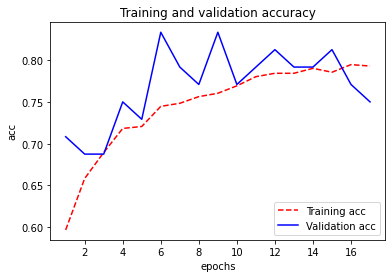

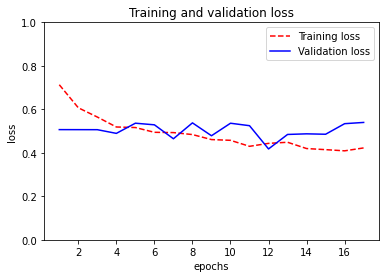

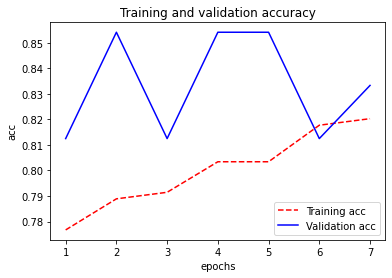

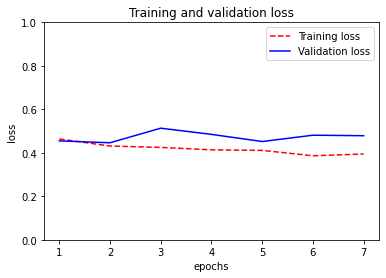

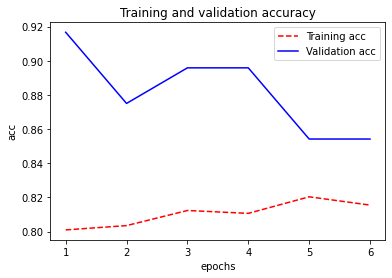

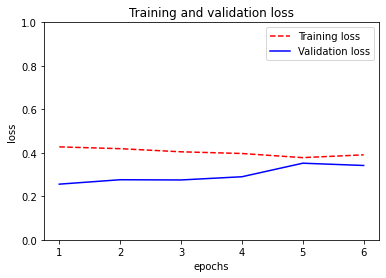

<Figure size 432x288 with 0 Axes>

In [17]:
i=0
for i in range(nds):
    i+=1
    print('****************************ENTRENAMIENTO NUMERO: ', str(i), '*******************************')
    df_totaltest= pd.read_csv("test.csv")
    df_totaleval= pd.read_csv("eval"+"-"+str(i)+".csv")
    df_totaltrain= pd.read_csv("train"+"-"+str(i)+".csv")
    
    df_totaltest['target2']=df_totaltest['target'].astype(str)
    df_totaleval['target2']=df_totaleval['target'].astype(str)
    df_totaltrain['target2']=df_totaltrain['target'].astype(str)
    
    #obtener casos unicos
    df_casos=df_totaltrain.drop_duplicates(subset = "Caso")
    df_class1 = df_casos[df_casos['target']==0]
    df_class2 = df_casos[df_casos['target']==1]
    
    num_class1 = len(df_class1.groupby(df_class1.Caso))
    num_class2 = len(df_class2.groupby(df_class2.Caso))
    num_total = num_class1 + num_class2
    weight_for_0 = (1 / num_class1) * (num_total / 2.0)
    weight_for_1 = (1 / num_class2) * (num_total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1} 
    
    print('Peso para clase 0: {:.2f}' .format(weight_for_0))
    print('Peso para clase 1: {:.2f}' .format(weight_for_1))
    
    model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(),
              metrics=[METRICS])
    
    train_datagen = ImageDataGenerator(
#     rescale=1.0/255.,
      preprocessing_function=preprocess_input,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='constant')

    validation_datagen  = ImageDataGenerator(
#     rescale = 1.0/255.,
      preprocessing_function=preprocess_input)

    test_datagen  = ImageDataGenerator(
#     rescale = 1.0/255.,
      preprocessing_function=preprocess_input)


    train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_totaltrain,
        directory=base_dir,
        x_col="image", y_col="target2",
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True,
        target_size=(IMAGE_SIZE, IMAGE_SIZE))
    
    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=df_totaleval,
        directory=base_dir,
        x_col="image", y_col="target2",
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=True,
        target_size=(IMAGE_SIZE, IMAGE_SIZE))
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=df_totaltest,
        directory=base_dir,
        x_col="image", y_col="target2",
        batch_size=1, #BATCH_SIZE
        class_mode='binary',
        shuffle=False,
        target_size=(IMAGE_SIZE, IMAGE_SIZE))
    
    steps_per_epoch = train_generator.n // BATCH_SIZE
    validation_steps = validation_generator.n // BATCH_SIZE
    
    history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = EPOCHS,
            validation_steps = validation_steps,
            verbose = 1,
            callbacks=[early_stopping_cb, checkpoint_cb, lr_scheduler],
            class_weight=class_weight
    )
    model.save('model-'+str(i)+'.h5')
    # Evaluating the model on Validation Dataset
    print('Evaluating the model on Validation Dataset:')
    model.evaluate(validation_generator, steps=validation_steps)
    
    print(history.history.keys())      
    acc      = history.history[     'acc' ]
    val_acc  = history.history[ 'val_acc' ]
    loss     = history.history[    'loss' ]
    val_loss = history.history['val_loss' ]

    epochs    = range(1,len(acc)+1,1) # obtener número de epochs

    plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
    plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
    plt.title ('Training and validation accuracy')
    plt.ylabel('acc')
    #plt.ylim(0,1)
    plt.xlabel('epochs')

    plt.legend()
    plt.figure()


    plt.plot  ( epochs,     loss, 'r--', label='Training loss'  )
    plt.plot  ( epochs, val_loss ,  'b', label='Validation loss' )
    plt.title ('Training and validation loss'   )
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.ylim(0,1)

    plt.legend()
    plt.figure()
          
    test_lost, test_acc= model.evaluate(test_generator)
    print ("Test Accuracy:", test_acc)
    test_examples = len(df_totaltest)
    print('Muestras de test', str(test_examples))
          
    # Getting the actual classes of the test dataset
    y_test = np.array([])
    num_batches = 0
    for _, y in test_generator:
        y_test = np.append(y_test, y)
        num_batches += 1
        if num_batches == math.ceil(test_examples / BATCH_SIZE):
            break
    y_test

    # Predicting output on the test dataset
    y_pred = model.predict(test_generator)

    # Computing the TPR and FPR values from the roc curve

    #fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    #auc = round((roc_auc_score(y_test, y_pred)), 2)
    #print('Area bajo la curva: ', str(auc))
    report, matrix = evaluate(model)
    print(report)
    print(matrix)
    #Plotting the ROC curve      
    #plot_roc_curve(fpr, tpr, label="test", auc=auc)
    #plt.show()
    ### Probabilities      
    result = predict_probs(model)
    to_local_csv(result, 'probabilities-'+str(i)+'1.csv', header=True)